# ***Questions***
* Why MinMaxScaler sometimes work better in Clustering?
* When should i use MinMaxScaler and StandardScaler?

# ***Analyzing sklearn Datasets***

# **Imports**

In [62]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tabulate import tabulate

plt.style.use("Solarize_Light2")

In [63]:
from sklearn.datasets import load_breast_cancer, load_iris

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, DBSCAN

from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from imblearn.over_sampling import RandomOverSampler

# **Global Functions**

In [64]:
def normalization(data, model):
  norm_data= pd.DataFrame(data=model.transform(data), columns=data.columns)

  return norm_data

In [65]:
from scipy.stats import mode

def remap_clusters(true_labels, predicted_clusters):
    labels = np.zeros_like(predicted_clusters)
    for cluster in np.unique(predicted_clusters):
        mask = (predicted_clusters == cluster)
        labels[mask] = mode(true_labels[mask], keepdims=True)[0]
    return labels

# **Cluster Metrics**

In [66]:
def calculate_accuracy(confusion_matrix) -> float:
    """
    Calculate accuracy from the confusion matrix.
    Accuracy is the ratio of correct predictions to total samples.

    Args:
    confusion_matrix (np.array): The confusion matrix.

    Returns:
    float: Accuracy value.
    """
    # Total correct predictions are the sum of the diagonal elements
    correct_predictions = np.trace(confusion_matrix)

    # Total samples is the sum of all elements in the confusion matrix
    total_samples = np.sum(confusion_matrix)

    # Calculate accuracy
    accuracy = correct_predictions / total_samples
    return accuracy

In [67]:
def cal_f1_score(confusion_mat):
    prf1 = []
    cm = np.array(confusion_mat)
    for i in range(cm.shape[0]):
        row_sum = np.sum(cm[i, :])
        col_sum = np.sum(cm[:, i])

        if row_sum == 0 or col_sum == 0:
            prf1.append(np.array([0, 0, 0]))
            continue

        recall = cm[i, i] / row_sum
        precision = cm[i, i] / col_sum

        if precision + recall == 0:
            f1 = 0
        else:
            f1 = (2 * recall * precision) / (precision + recall)

        prf1.append(np.array([precision, recall, f1]))

    return np.array(prf1)

In [68]:
def metrics_table(method_name, prf_array, accuracy, w_precision, w_recall, w_f1):
    rows = []

    for i, (p, r, f1) in enumerate(prf_array):
        rows.append([method_name, i, f"{p:.2f}", f"{r:.2f}", f"{f1:.2f}", ""])

    # Summary row with weighted metrics
    rows.append([
        method_name, "Overall",
        f"{w_precision:.3f}", f"{w_recall:.3f}", f"{w_f1:.3f}", f"{accuracy:.2%}"
    ])

    print(tabulate(
        rows,
        headers=["Method", "Cluster", "Precision", "Recall", "F1 Score", "Accuracy"],
        tablefmt="grid"
    ))


In [69]:
def calculate_metrics(cm):
    # Accuracy
    acc_kmeans = calculate_accuracy(cm)

    # Precision, recall, F1
    prf_kmeans = np.array(cal_f1_score(cm))

    # Weighted Precision, recall, F1
    weights_k = np.sum(cm, axis=1)

    # Weighted Precision, Recall, F1 for K-Means
    wp_k = np.sum(prf_kmeans[:, 0] * weights_k) / np.sum(weights_k)
    wr_k = np.sum(prf_kmeans[:, 1] * weights_k) / np.sum(weights_k)
    wf1_k = np.sum(prf_kmeans[:, 2] * weights_k) / np.sum(weights_k)

    metrics_table("K-Means", prf_kmeans, acc_kmeans, wp_k, wr_k, wf1_k)

# .
# **Breast Cancer**
* Diagnosis (M = malignant = 0, B = benign = 1)
* Analyzing **binary** data involves examining the frequency of each category and understanding relationships with other variables.



## 0 Load


In [70]:
bc_x, bc_y = load_breast_cancer(return_X_y=True, as_frame=True)

In [71]:
bc_df = bc_x.copy()
bc_df["is benign"] = bc_y.astype(np.int8).copy()
bc_nominal_label = bc_df["is benign"].map({0: "malignant", 1: "benign"}).rename("label").copy()

In [72]:
bc_df

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
0             0.27760         0.30010              0.14710         0.2419   
1             0.07864         0.08690              0.07017         0.1812   
2             0.15990         0.19740              0.12790         0.2069   
3             0.28390         0.24140              0.10520         0.2597   
4             0.13280         0.19800              0.10430         0.1809   
..                ...             ...                  ...            ...   
564           0.11590         0.24390              0.13890         0.1726   
565           0.10340         0.14400              0.09791         0.1752   
566           0.10230         0.09251              0.05302         0.1590   
567           0.27700         0.35140              0.15200         0.2397   
568           0.04362         0.00000              0.00000         0.1587   

     mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                   0.07871  ...          17.33           184.60      2019.0   
1                   0.05667  ...          23.41           158.80      1956.0   
2                   0.05999  ...          25.53           152.50      1709.0   
3                   0.09744  ...          26.50            98.87       567.7   
4                   0.05883  ...          16.67           152.20      1575.0   
..                      ...  ...            ...              ...         ...   
564                 0.05623  ...          26.40           166.10      2027.0   
565                 0.05533  ...          38.25           155.00      1731.0   
566                 0.05648  ...          34.12           126.70      1124.0   
567                 0.07016  ...          39.42           184.60      1821.0   
568                 0.05884  ...          30.37            59.16       268.6   

     worst smoothness  worst compactness  worst concavity  \
0             0.16220            0.66560           0.7119   
1             0.12380            0.18660           0.2416   
2             0.14440            0.42450           0.4504   
3             0.20980            0.86630           0.6869   
4             0.13740            0.20500           0.4000   
..                ...                ...              ...   
564           0.14100            0.21130           0.4107   
565           0.11660            0.19220           0.3215   
566           0.11390            0.30940           0.3403   
567           0.16500            0.86810           0.9387   
568           0.08996            0.06444           0.0000   

     worst concave points  worst symmetry  worst fractal dimension  is benign  
0                  0.2654          0.4601                  0.11890          0  
1                  0.1860          0.2750                  0.08902          0  
2                  0.2430          0.3613                  0.08758          0  
3                  0.2575          0.6638                  0.17300          0  
4                  0.1625          0.2364        

## 1 Exploratory Data Analysis (EDA)

### info

In [73]:
bc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

### describe

In [74]:
bc_df.describe()

mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       mean symmetry  mean fractal dimension  ...  worst texture  \
count     569.000000              569.000000  ...     569.000000   
mean        0.181162                0.062798  ...      25.677223   
std         0.027414                0.007060  ...       6.146258   
min         0.106000                0.049960  ...      12.020000   
25%         0.161900                0.057700  ...      21.080000   
50%         0.179200                0.061540  ...      25.410000   
75%         0.195700                0.066120  ...      29.720000   
max         0.304000                0.097440  ...      49.540000   

       worst perimeter   worst area  worst smoothness  worst compactness  \
count       569.000000   569.000000        569.000000         569.000000   
mean        107.261213   880.583128          0.132369           0.254265   
std          33.602542   569.356993          0.022832           0.157336   
min          50.410000   185.200000          0.071170           0.027290   
25%          84.110000   515.300000          0.116600           0.147200   
50%          97.660000   686.500000          0.131300           0.211900   
75%         125.400000  1084.000000          0.146000           0.339100   
max         251.200000  4254.000000          0.222600           1.058000   

       worst concavity  worst concave points  worst symmetry  \
count       569.000000            569.000000      569.000000   
mean          0.272188              0.114606        0.290076   
std           0.208624              0.065732        0.061867   
min           0.000000              0.000000        0.156500   
25%           0.114500              0.064930        0.250400   
50%           0.226700              0.099930        0.282200   
75%           0.382900              0.161400        0.317900   
max           1.252000              0.291000        0.663800   

       worst fractal dimension   is benign  
count               569.000000  569.000000  
mean                  0.083946    0.627417  
std                   0.018061    0.483918  
min                   0.055040    0.000000  
25%                   0.071460    0.000000  
50%                   0.080040    1.000000  
75%                   0.092080    1.000000  
max                   0.207500    1.000000  

[8 rows x 31 columns]

### values count

In [75]:
bc_df["is benign"].value_counts()

is benign
1    357
0    212
Name: count, dtype: int64

### correlation

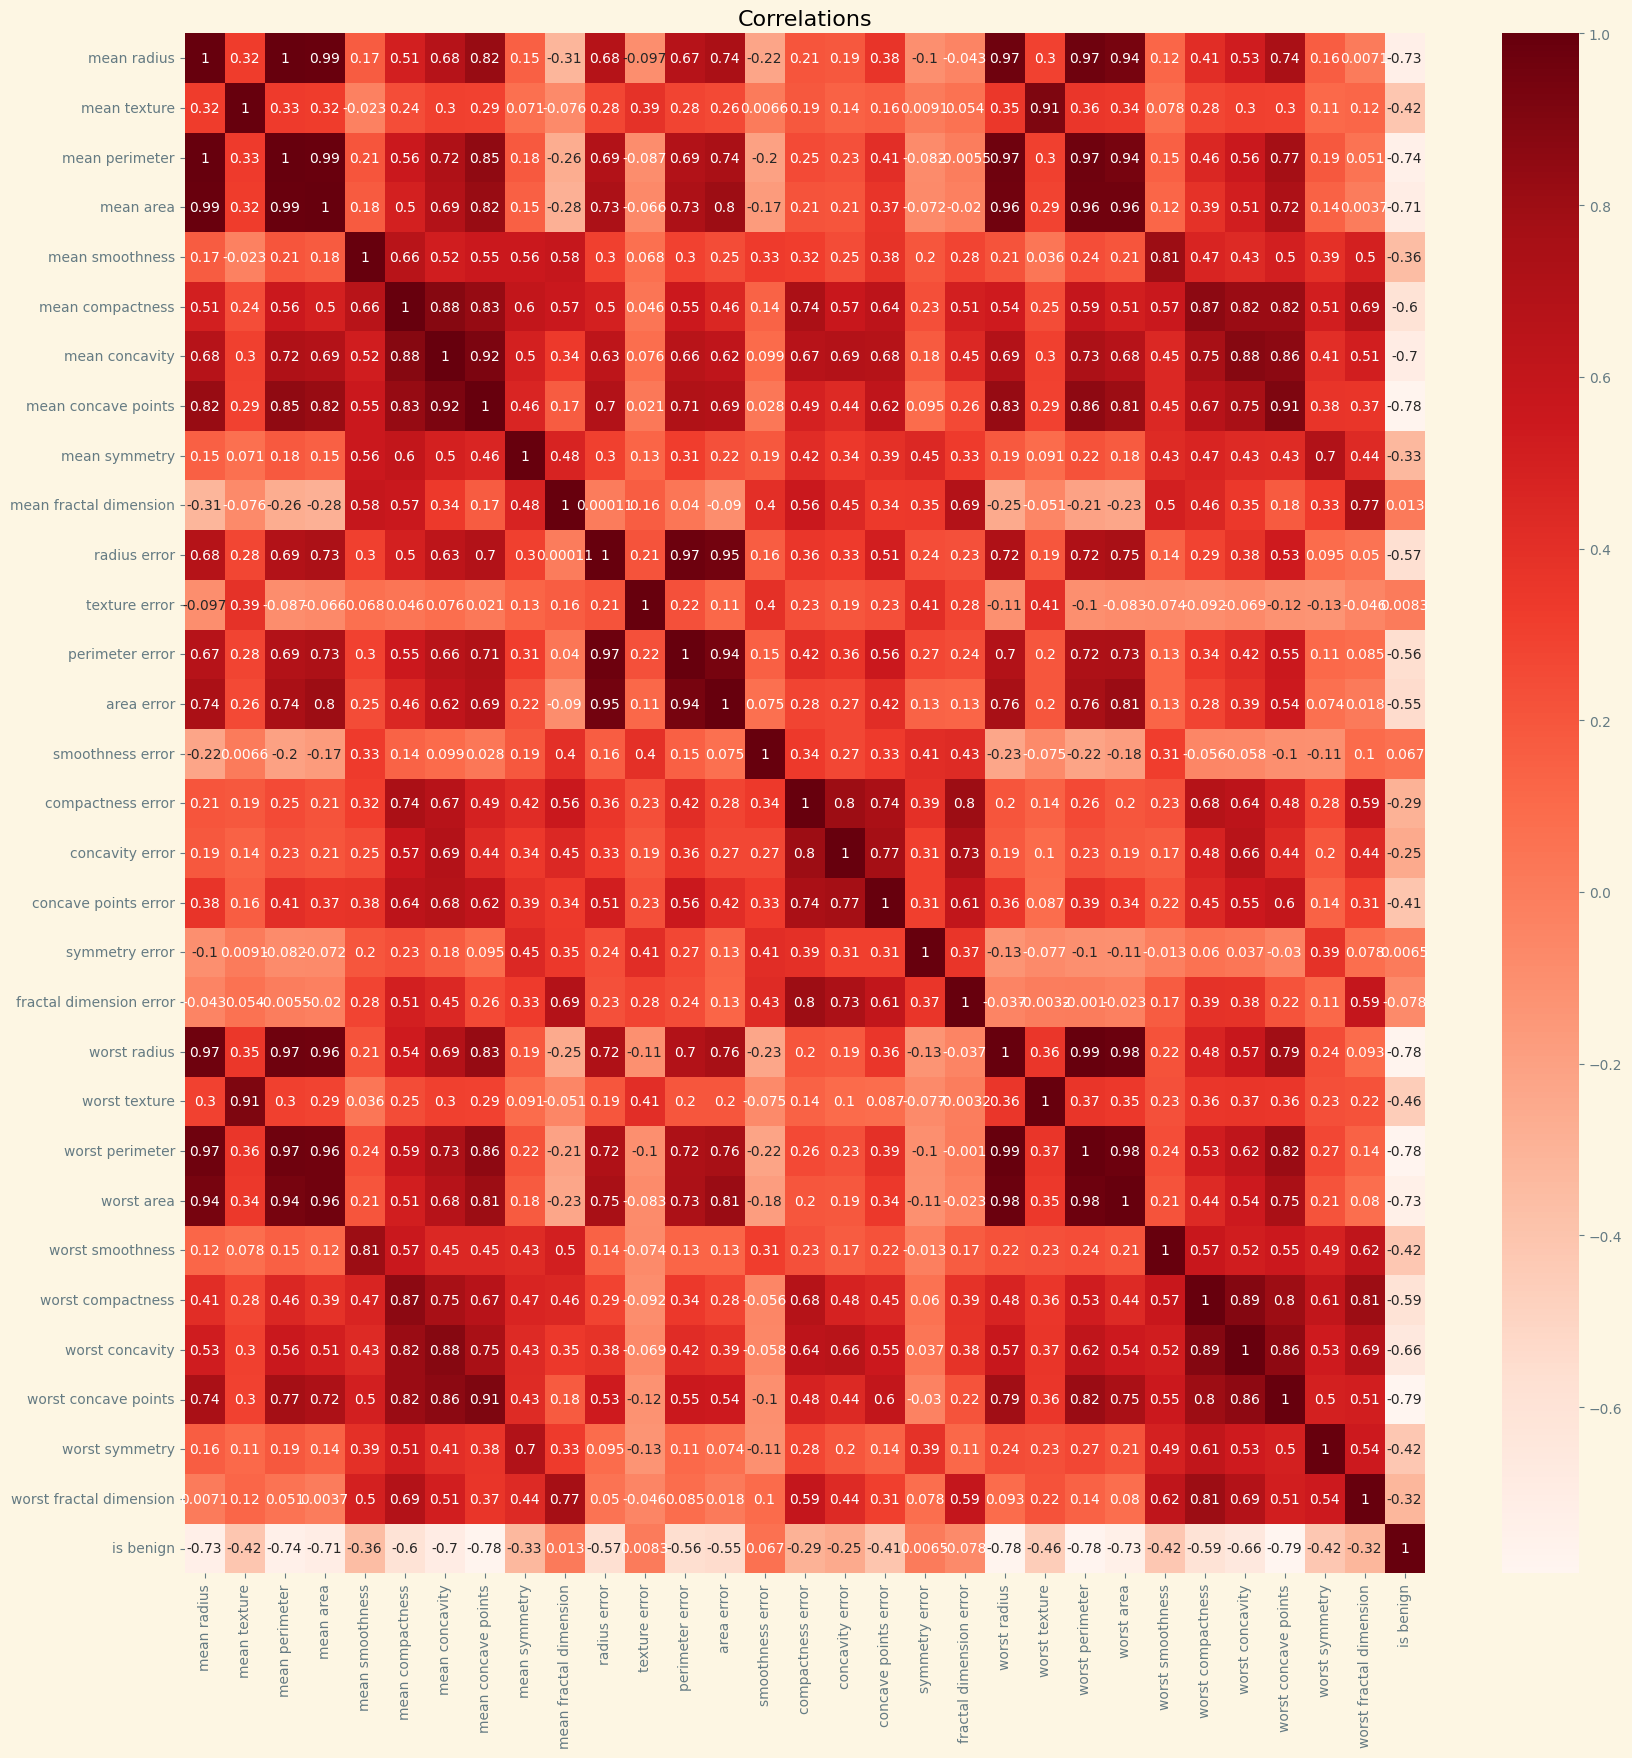

In [76]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(bc_df.corr(), annot=True, cmap="Reds", ax=ax)

plt.title("Correlations")
plt.show()

### histogram

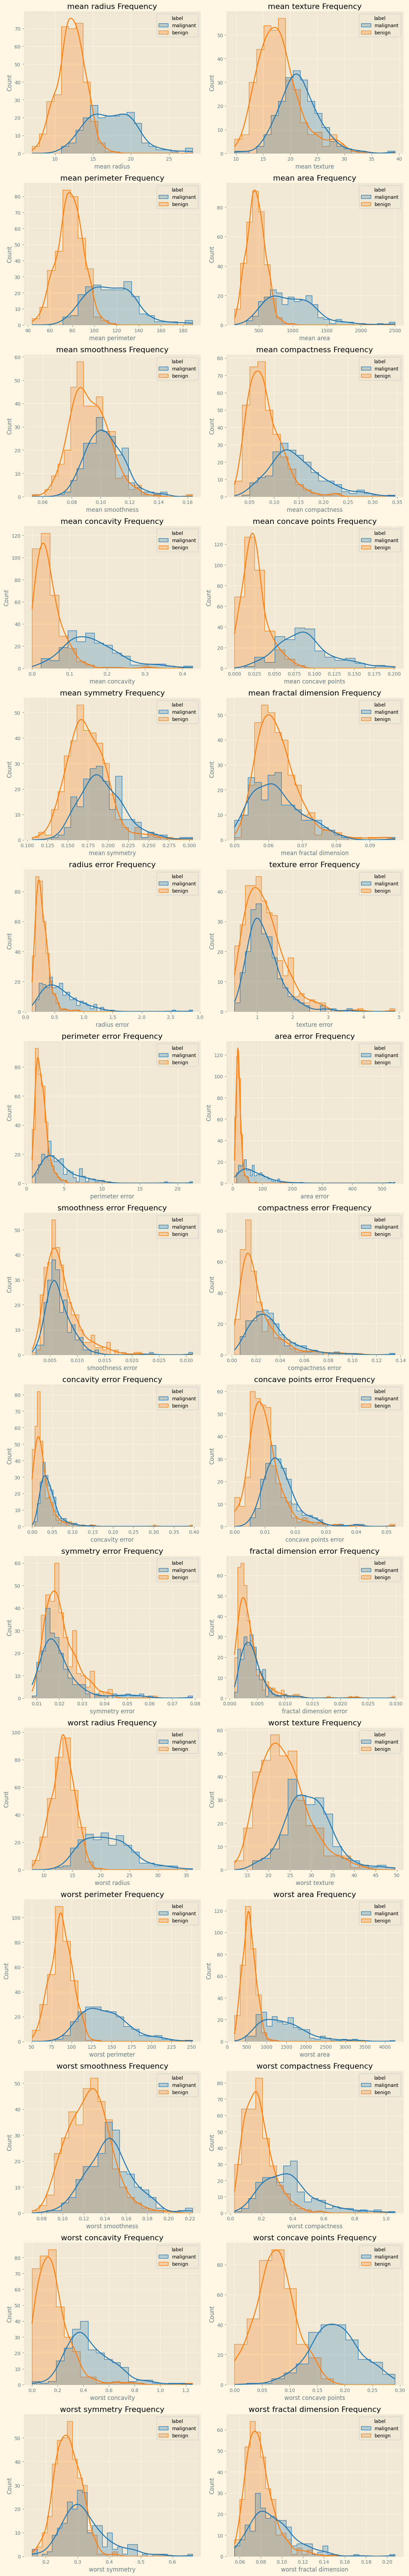

In [77]:
cols = bc_df.columns.drop('is benign')  # Optional: exclude target column if needed
num_cols = len(cols)
cols_per_row = 2
num_rows = (num_cols + 1) // cols_per_row

plt.figure(figsize=(12, num_rows * 5))

for idx, col_name in enumerate(cols, start=1):
    plt.subplot(num_rows, cols_per_row, idx)
    sns.histplot(data=bc_df, x=col_name, hue=bc_nominal_label, palette="tab10", element="step", kde=True)
    plt.title(f"{col_name} Frequency")

plt.tight_layout()
plt.show()

# 0, 2, 3, 6, 7, 10, 12, 13, 20, 22, 23, 27

### pie chart

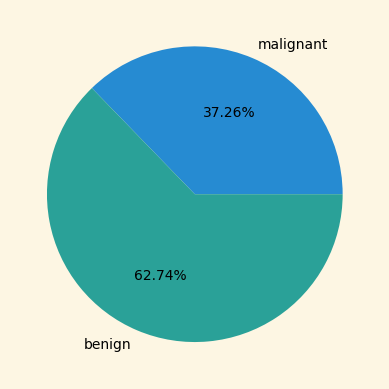

In [78]:
plt.pie(x=bc_nominal_label.value_counts(sort=False), autopct="%.2f%%", labels=bc_nominal_label.unique())
plt.show()

### scatter plot

#### vs is benign

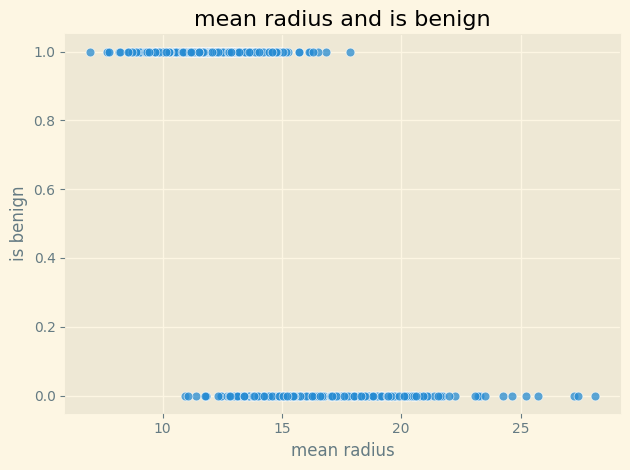

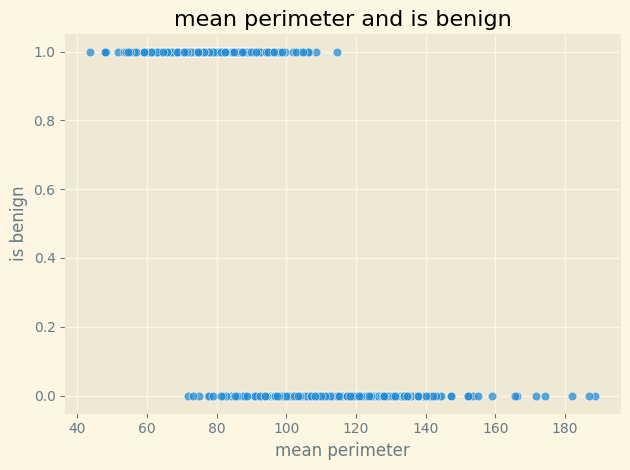

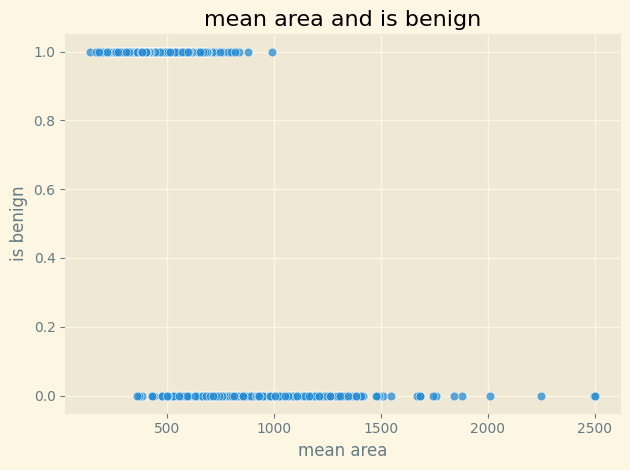

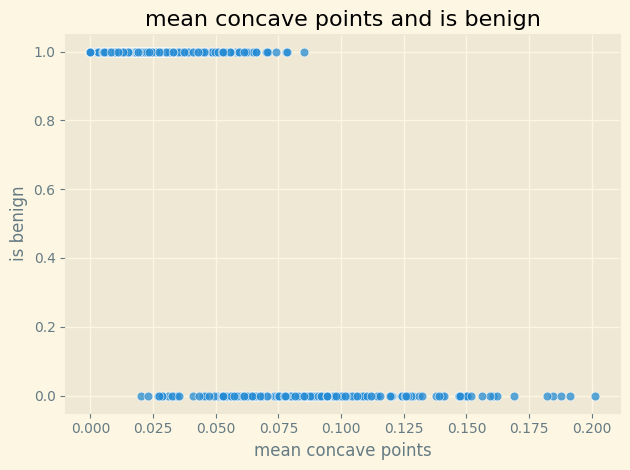

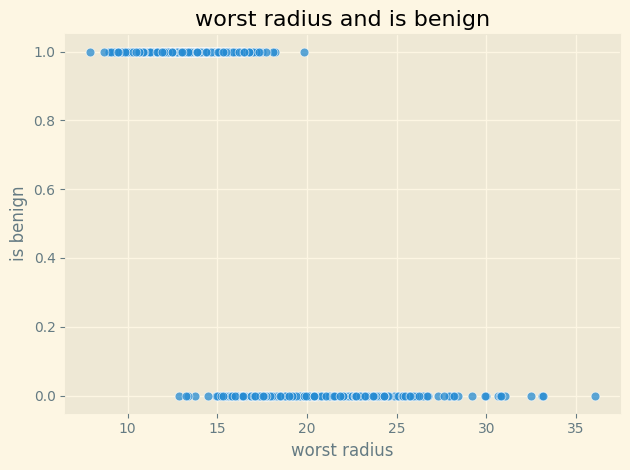

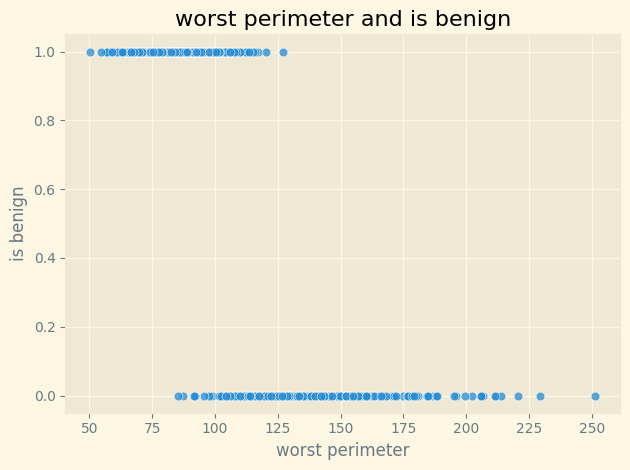

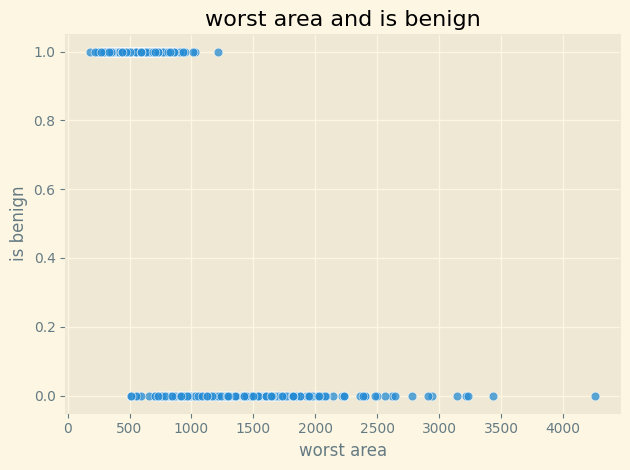

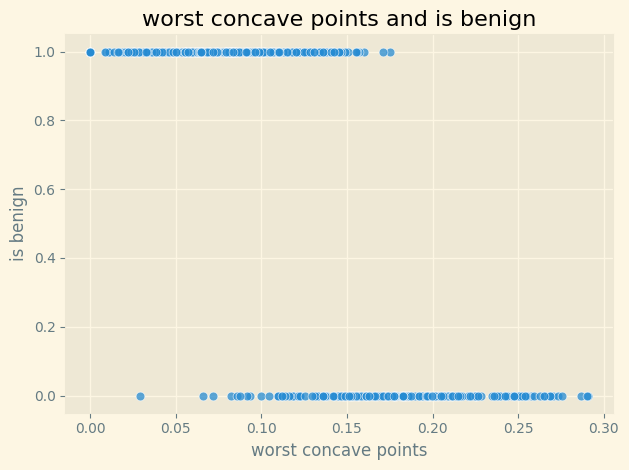

In [79]:
col_names = bc_df.columns[[0, 2, 3, 7, 20, 22, 23, 27]]


for col_name in col_names:
    sns.scatterplot(data=bc_df, x=col_name, y="is benign", s=40, alpha=0.75)
    plt.title(f"{col_name} and is benign")
    plt.tight_layout()
    plt.show()

#### pairs

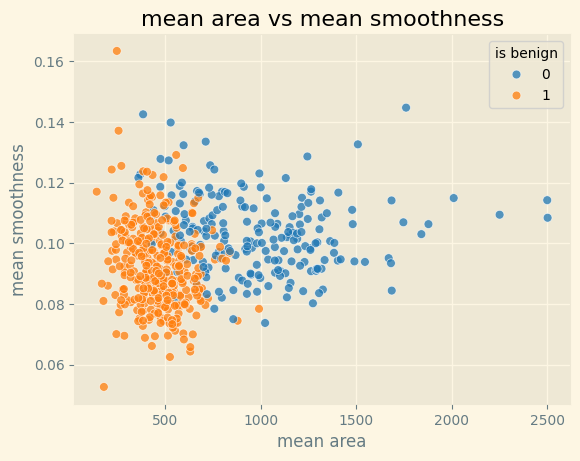

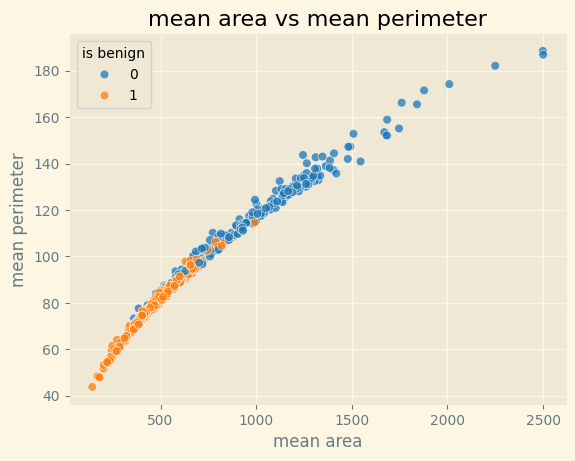

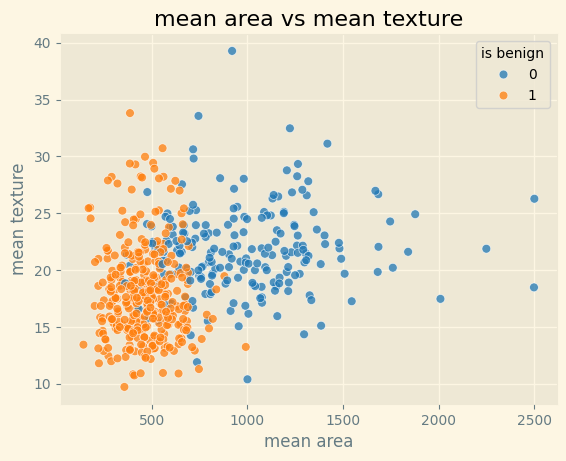

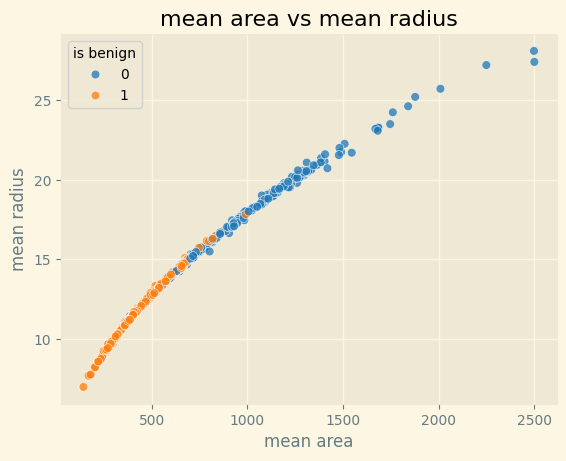

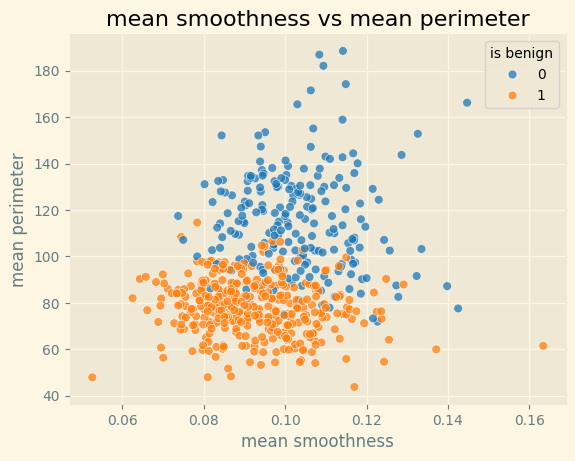

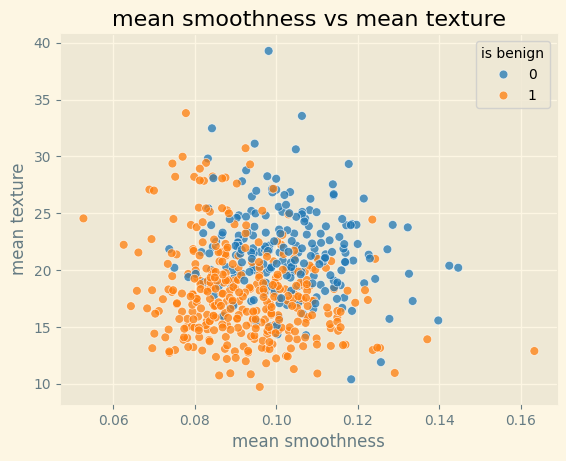

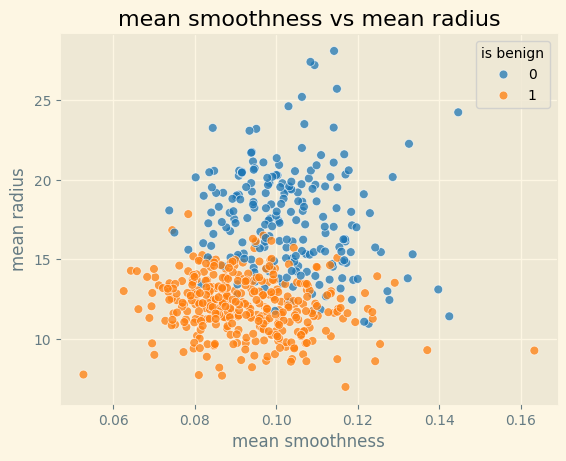

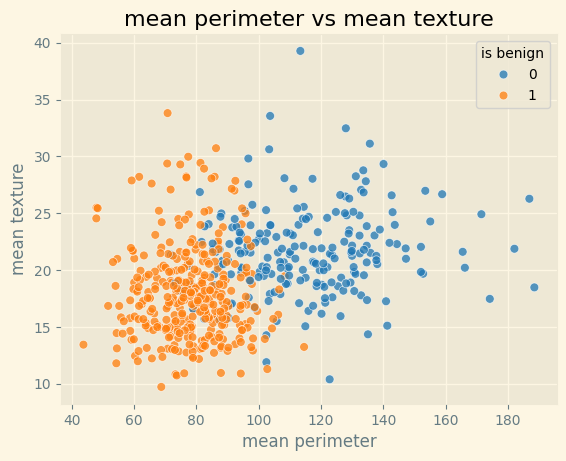

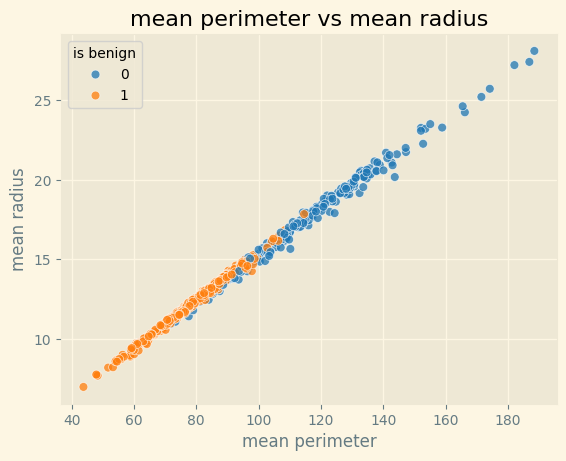

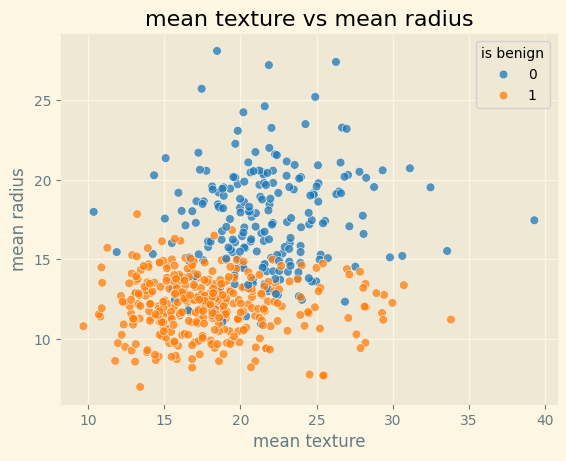

In [80]:
col_names = ["mean area", "mean smoothness", "mean perimeter", "mean texture", "mean radius"]

for i in range(len(col_names)):
    for j in range(i + 1, len(col_names)):
          sns.scatterplot(data=bc_df, x=col_names[i], y=col_names[j], hue="is benign", palette="tab10", s=40, alpha=0.75)
          plt.xlabel(col_names[i])
          plt.ylabel(col_names[j])
          plt.title(f"{col_names[i]} vs {col_names[j]}")
          plt.show()

## 2 Normalization and Split Dataset

In [81]:
X_train, X_test, y_train, y_test = train_test_split(bc_df.drop(["is benign"], axis=1), bc_df["is benign"], test_size=0.33, random_state=42)

In [82]:
model = StandardScaler().fit(bc_df.drop(["is benign"], axis=1))
X_train = normalization(X_train, model)
X_test = normalization(X_test, model)

### balance data

In [83]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train, y_train)

In [84]:
y_train.value_counts()

is benign
0    236
1    236
Name: count, dtype: int64

## 3 Apply ML Models

### Logistic regression
Logistic (logit link) or log-risk/log-binomial (log link) regression are the most common GLM to fit to a binary outcome.

#### all columns

In [85]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)

report = classification_report(y_test, y_pred_log, digits=2)
print(report)

print(classification_report(y_train, log_model.predict(X_train), digits=2)) # check for overfitting

              precision    recall  f1-score   support

           0       0.94      0.99      0.96        67
           1       0.99      0.97      0.98       121

    accuracy                           0.97       188
   macro avg       0.97      0.98      0.97       188
weighted avg       0.97      0.97      0.97       188

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       236
           1       0.97      0.99      0.98       236

    accuracy                           0.98       472
   macro avg       0.98      0.98      0.98       472
weighted avg       0.98      0.98      0.98       472



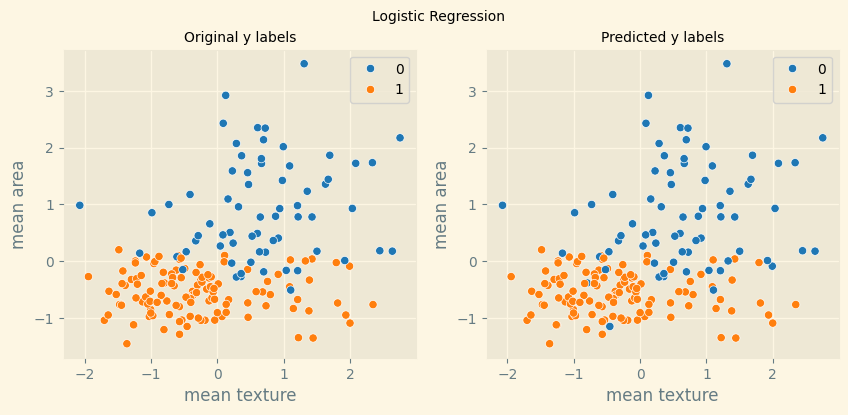

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle("Logistic Regression", fontsize=10)

sns.scatterplot(data=X_test, x="mean texture", y="mean area", hue=np.array(y_test), ax=axes[0], palette="tab10")
axes[0].set_title("Original y labels", fontsize=10)

sns.scatterplot(data=X_test, x="mean texture", y="mean area", hue=y_pred_log, ax=axes[1], palette="tab10")
axes[1].set_title("Predicted y labels", fontsize=10)

plt.show()

#### selected columns

In [87]:
log_model = LogisticRegression()
log_model.fit(X_train.iloc[:, [0, 2, 3, 7, 20, 22, 23, 27]], y_train)

y_pred = log_model.predict(X_test.iloc[:, [0, 2, 3, 7, 20, 22, 23, 27]])
y_true = y_test

report = classification_report(y_true, y_pred, digits=2)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95        67
           1       0.99      0.95      0.97       121

    accuracy                           0.96       188
   macro avg       0.95      0.97      0.96       188
weighted avg       0.96      0.96      0.96       188



### KNN classification

In [88]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

report = classification_report(y_true=y_test, y_pred=y_pred_knn)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.94      0.90        67
           1       0.97      0.92      0.94       121

    accuracy                           0.93       188
   macro avg       0.91      0.93      0.92       188
weighted avg       0.93      0.93      0.93       188



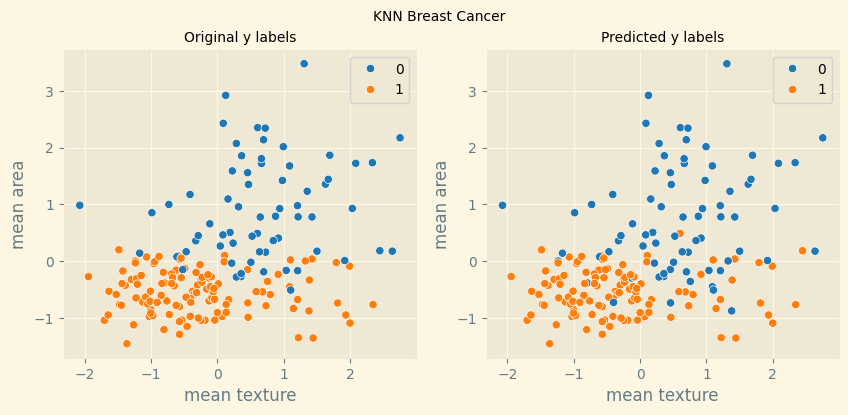

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle("KNN Breast Cancer", fontsize=10)

sns.scatterplot(data=X_test, x="mean texture", y="mean area", hue=np.array(y_test), ax=axes[0], palette="tab10")
axes[0].set_title("Original y labels", fontsize=10)

sns.scatterplot(data=X_test, x="mean texture", y="mean area", hue=y_pred_knn, ax=axes[1], palette="tab10")
axes[1].set_title("Predicted y labels", fontsize=10)

plt.show()

### K-Means Clustering

In [90]:
kmeans = KMeans(n_clusters=2, n_init='auto')
y_pred_k_means = kmeans.fit_predict(X_train)

#### confusing matrix

In [91]:
y_pred_k_means_remapped = remap_clusters(y_train, y_pred_k_means)
cm_k_means = confusion_matrix(y_train, y_pred_k_means_remapped)

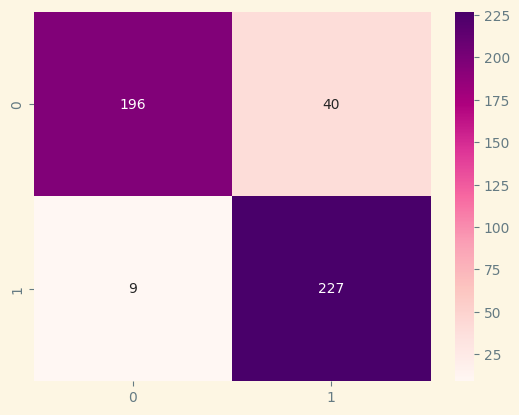

+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| K-Means  | 0         |       0.96  |    0.83  |      0.89  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 1         |       0.85  |    0.96  |      0.9   |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | Overall   |       0.903 |    0.896 |      0.896 | 89.62%     |
+----------+-----------+-------------+----------+------------+------------+


In [92]:
sns.heatmap(cm_k_means, annot=True, fmt='d', cmap='RdPu')
plt.show()

calculate_metrics(cm=cm_k_means)

#### plotting

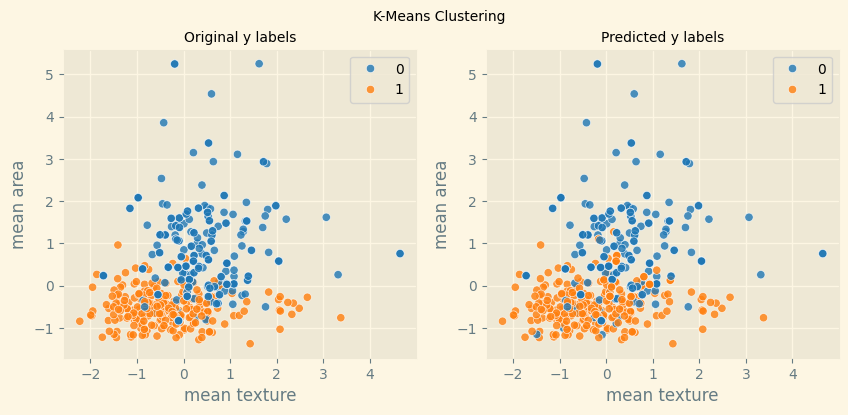

In [93]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4)) # dpi here

plt.suptitle("K-Means Clustering", fontsize=10)

sns.scatterplot(data=X_train, x="mean texture", y="mean area", hue=np.array(y_train), ax=axes[0], palette="tab10", alpha=0.8)
axes[0].set_title("Original y labels", fontsize=10)

sns.scatterplot(data=X_train, x="mean texture", y="mean area", hue=y_pred_k_means_remapped, ax=axes[1], palette="tab10", alpha=0.8)
axes[1].set_title("Predicted y labels", fontsize=10)

plt.show()

# .
# **Iris**

## 0 Load

In [94]:
iris_X, iris_y = load_iris(return_X_y=True, as_frame=True)

In [95]:
iris_df = iris_X.copy()
iris_df["type"] = iris_y.astype(np.int8).copy()

In [96]:
iris_df

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     type  
0       0  
1       0  
2       0  
3       0  
4       0  
..    ...  
145     2  
146     2  
147     2  
148     2  
149     2  

[150 rows x 5 columns]

## 1 Exploratory Data Analysis (EDA)

### info

In [97]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   type               150 non-null    int8   
dtypes: float64(4), int8(1)
memory usage: 5.0 KB


### describe

In [98]:
iris_df.describe()

sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)        type  
count        150.000000  150.000000  
mean           1.199333    1.000000  
std            0.762238    0.819232  
min            0.100000    0.000000  
25%            0.300000    0.000000  
50%            1.300000    1.000000  
75%            1.800000    2.000000  
max            2.500000    2.000000

### value counts

In [99]:
iris_df["type"].value_counts()

type
0    50
1    50
2    50
Name: count, dtype: int64

### correlations

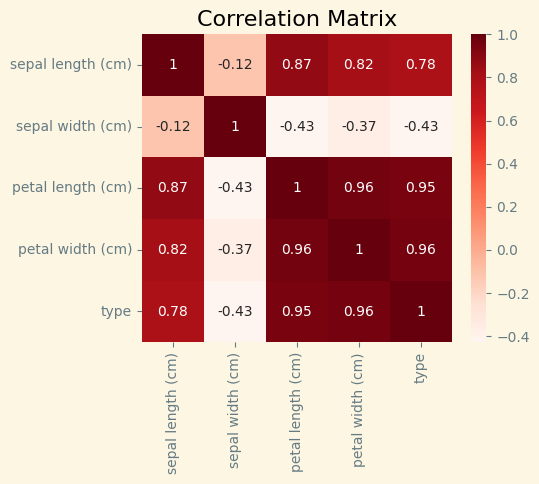

In [100]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(data=iris_df.corr(), cmap="Reds", annot=True, ax=ax)

plt.title("Correlation Matrix")
plt.show()

### histograms

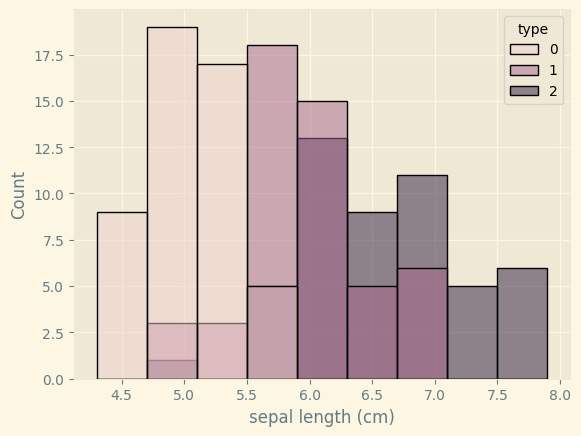

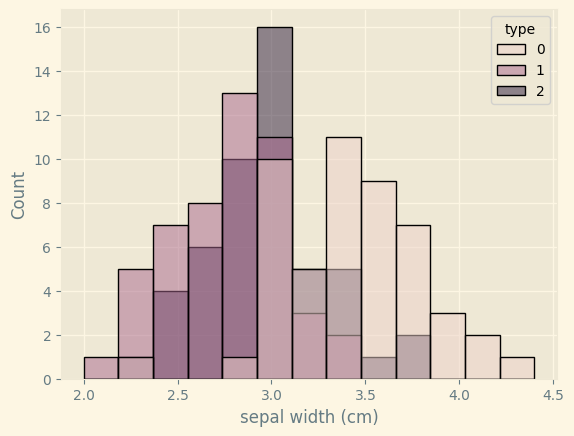

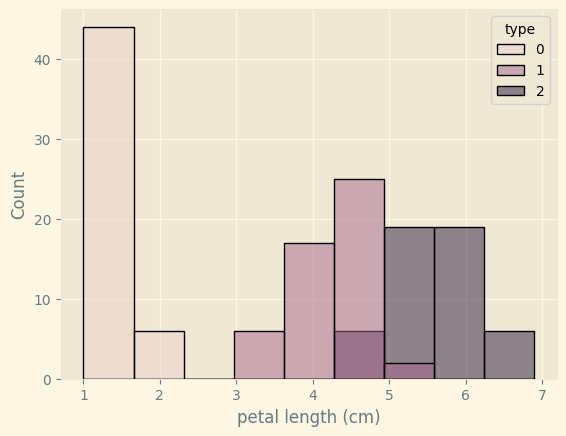

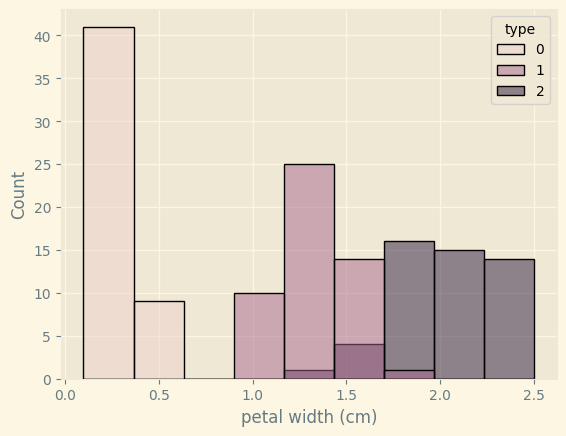

In [101]:
for col in iris_X.columns:
    sns.histplot(data=iris_df, x=col, hue="type")
    plt.show()

### scatter plots

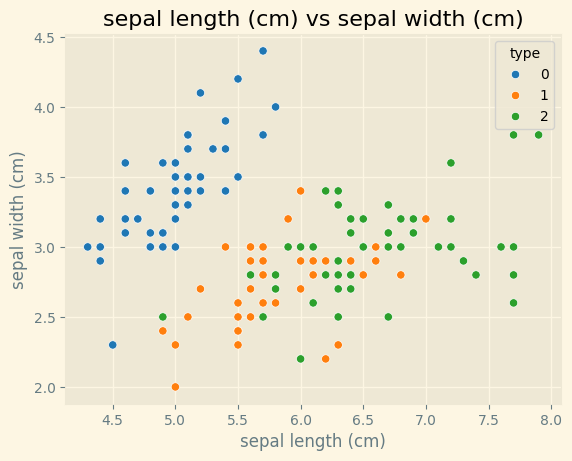

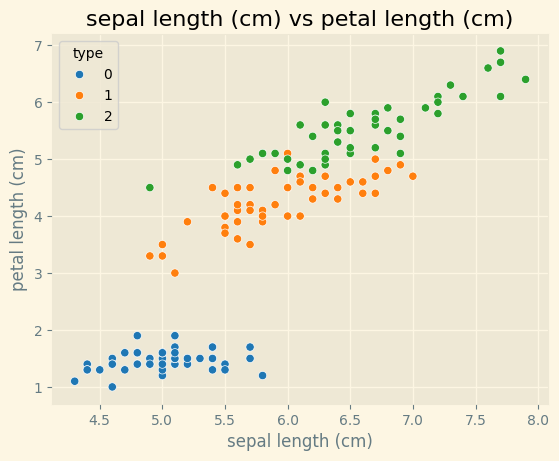

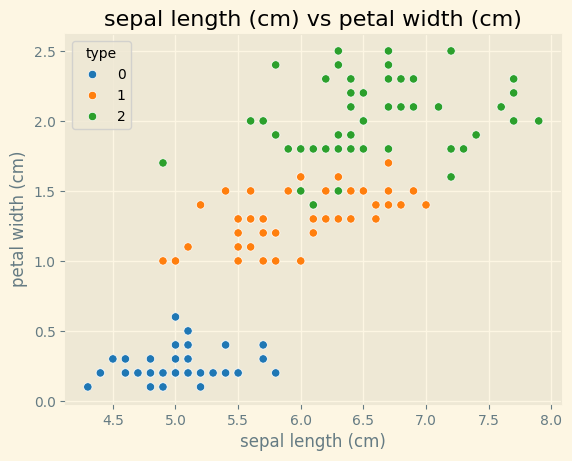

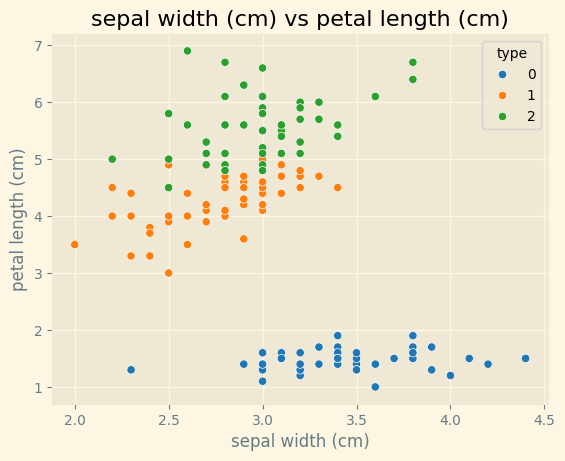

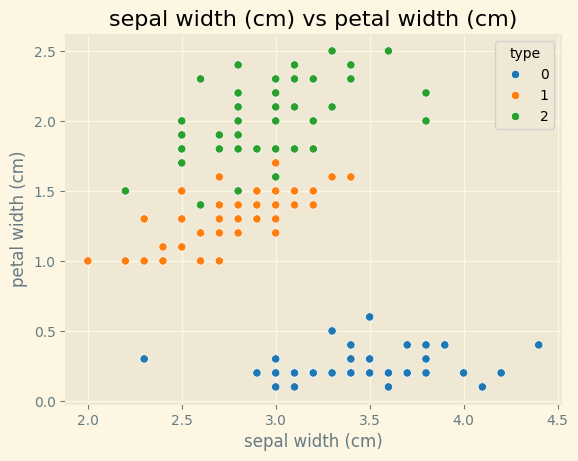

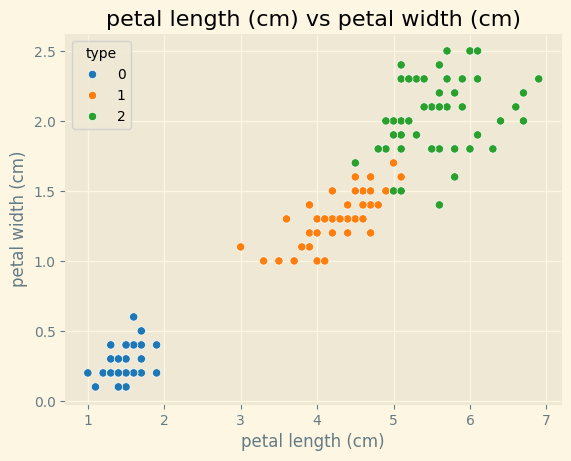

In [102]:
cols_name = iris_X.columns
for i in range(len(cols_name)):
    for j in range(i + 1, len(cols_name)):
        sns.scatterplot(data=iris_df, x=cols_name[i], y=cols_name[j], hue="type", palette="tab10")

        plt.title(f"{cols_name[i]} vs {cols_name[j]}")
        plt.show()

## 2 Normalization

In [103]:
iris_norm = normalization(data=iris_X, model=StandardScaler().fit(iris_X))
iris_norm_min_max = normalization(data=iris_X, model=MinMaxScaler().fit(iris_X))

## 3 Apply ML Models

### K-Means
* normalized with StandardScaler
* in apply to all columns MinMaxScaler did better than StandardScaler
* in apply to selected columns results are same

#### function

In [104]:
def k_means(X_train, y_train, k, data):
    kmeans = KMeans(n_clusters=k, n_init='auto')
    y_pred_k_means = kmeans.fit_predict(X_train)

    y_pred_k_means_remapped = remap_clusters(y_train, y_pred_k_means)
    cm_k_means = confusion_matrix(y_train, y_pred_k_means_remapped)

    sns.heatmap(cm_k_means, annot=True, fmt='d', cmap='RdPu')
    plt.show()

    calculate_metrics(cm=cm_k_means)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4)) # dpi here

    plt.suptitle("K-Means Clustering", fontsize=10)

    sns.scatterplot(data=data, x="petal length (cm)", y="petal width (cm)", hue=y_train, ax=axes[0], palette="tab10", alpha=0.8)
    axes[0].set_title("Original y labels", fontsize=10)

    sns.scatterplot(data=data, x="petal length (cm)", y="petal width (cm)", hue=y_pred_k_means_remapped, ax=axes[1], palette="tab10", alpha=0.8)
    axes[1].set_title("Predicted y labels", fontsize=10)

    plt.show()

#### apply to all columns

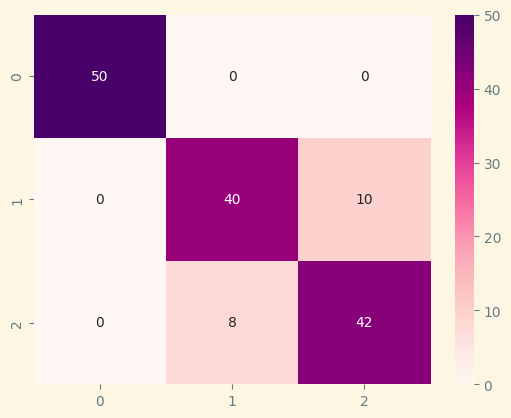

+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| K-Means  | 0         |        1    |     1    |       1    |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 1         |        0.83 |     0.8  |       0.82 |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 2         |        0.81 |     0.84 |       0.82 |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | Overall   |        0.88 |     0.88 |       0.88 | 88.00%     |
+----------+-----------+-------------+----------+------------+------------+


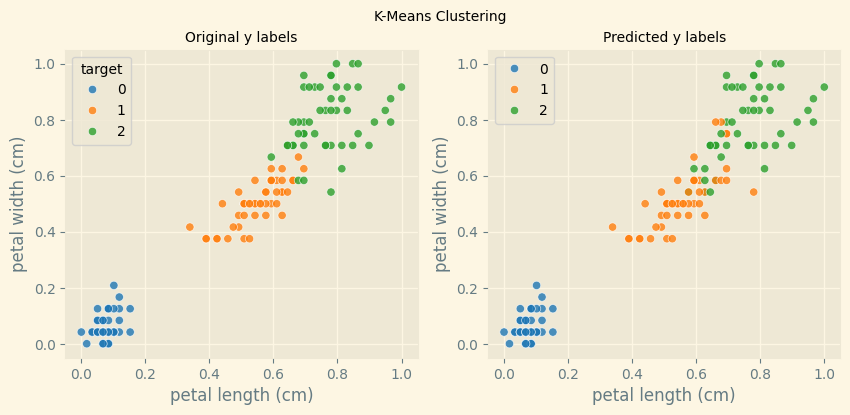

In [105]:
k_means(X_train=iris_norm_min_max, y_train=iris_y, k=3, data=iris_norm_min_max)

#### apply to selected columns

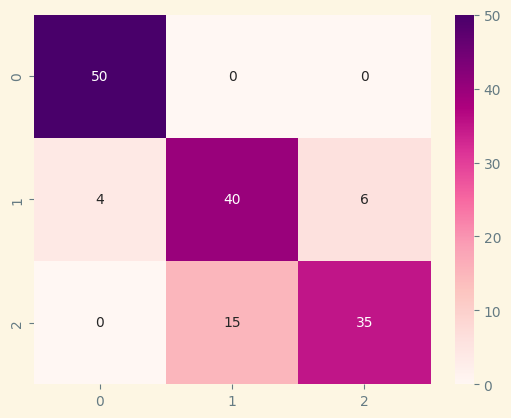

+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| K-Means  | 0         |       0.93  |    1     |      0.96  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 1         |       0.73  |    0.8   |      0.76  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 2         |       0.85  |    0.7   |      0.77  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | Overall   |       0.836 |    0.833 |      0.831 | 83.33%     |
+----------+-----------+-------------+----------+------------+------------+


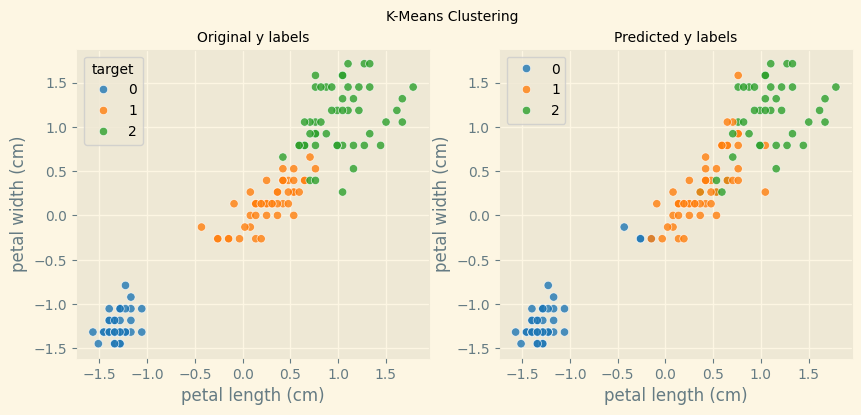

In [106]:
k_means(X_train=iris_norm.iloc[:, [0, 3]], y_train=iris_y, k=3, data=iris_norm)

### DB SCAN
* normalized with MinMaxScaler
* clustering is better with MinMaxScaler than StandardScaler
* finding the optimal eps is easier with MinMaxScaler

#### function

In [107]:
def db_scan(X_train, y_train, eps, min_sample, data):
    dbscan = DBSCAN(eps=eps, min_samples=min_sample)
    y_pred_db_scan = dbscan.fit_predict(X_train)

    # remove noise
    mask = y_pred_db_scan != -1
    if np.sum(mask) == 0:
        print("All points were classified as noise. Try increasing eps or decreasing min_samples.")
        return

    # Raw cm
    cm_not_mapped = confusion_matrix(y_train, y_pred_db_scan)
    sns.heatmap(cm_not_mapped, annot=True, fmt='d', cmap='RdPu')
    plt.title("cm not mapped with noises")
    plt.show()

    X_train_no_noise = X_train[mask].copy()
    y_train_no_noise = y_train[mask].copy()
    y_pred_db_scan = y_pred_db_scan[mask]
    data_no_noise = data[mask].copy()

    y_pred_db_scan_remapped = remap_clusters(y_train_no_noise, y_pred_db_scan)
    cm_db_scan = confusion_matrix(y_train_no_noise, y_pred_db_scan_remapped)

    sns.heatmap(cm_db_scan, annot=True, fmt='d', cmap='RdPu')
    plt.show()

    calculate_metrics(cm=cm_db_scan)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    plt.suptitle("DBSCAN Clustering", fontsize=10)

    sns.scatterplot(data=data, x="petal length (cm)", y="petal width (cm)", hue=y_train, ax=axes[0], palette="tab10", alpha=0.8)
    axes[0].set_title("Original y labels", fontsize=10)

    sns.scatterplot(data=data_no_noise, x="petal length (cm)", y="petal width (cm)", hue=y_pred_db_scan_remapped, ax=axes[1], palette="tab10", alpha=0.8)
    axes[1].set_title("Predicted y labels", fontsize=10)

    plt.show()

#### apply to all columns

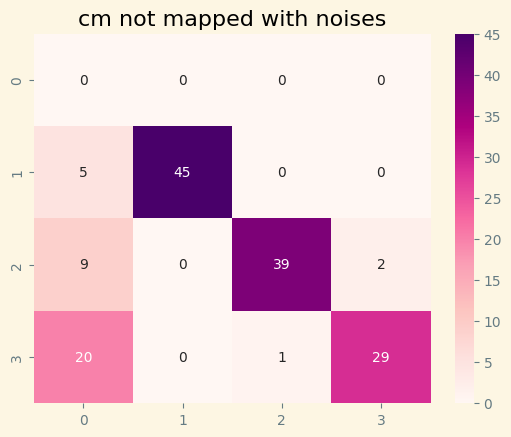

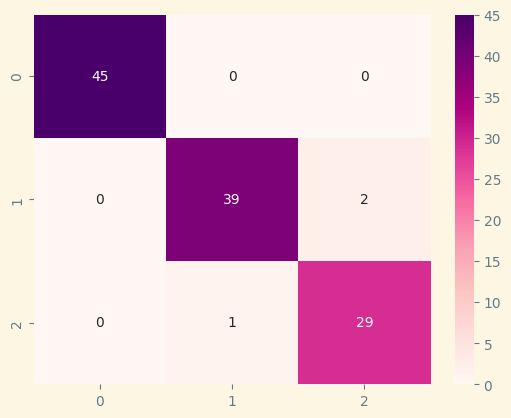

+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| K-Means  | 0         |       1     |    1     |      1     |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 1         |       0.97  |    0.95  |      0.96  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 2         |       0.94  |    0.97  |      0.95  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | Overall   |       0.974 |    0.974 |      0.974 | 97.41%     |
+----------+-----------+-------------+----------+------------+------------+


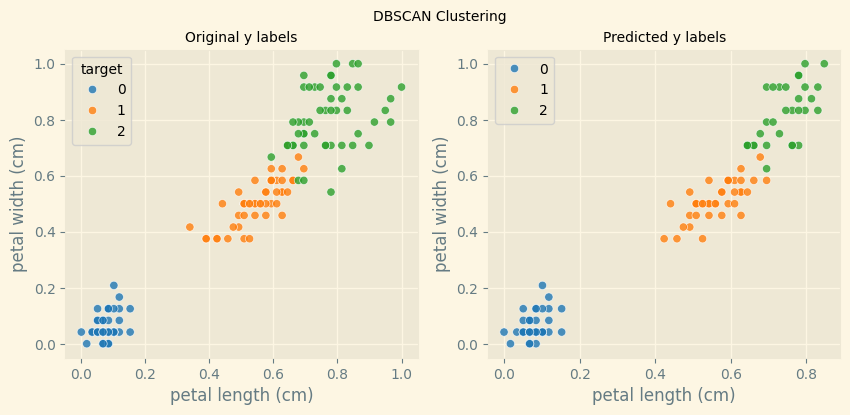

In [108]:
db_scan(X_train=iris_norm_min_max, y_train=iris_y, eps=0.128, min_sample=5, data=iris_norm_min_max)

#### apply to selected columns

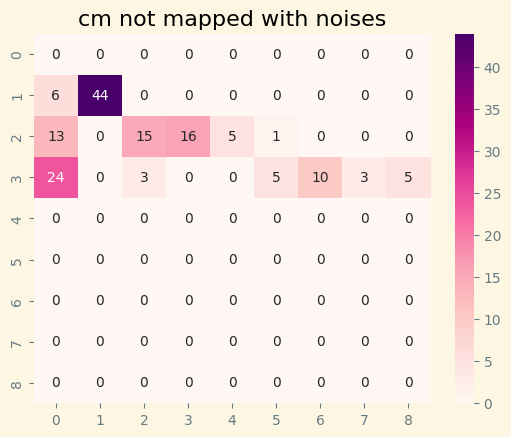

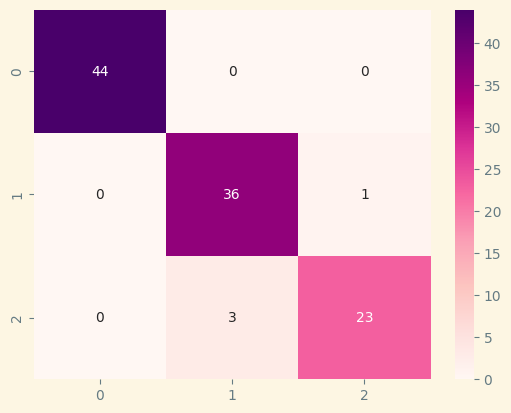

+----------+-----------+-------------+----------+------------+------------+
| Method   | Cluster   |   Precision |   Recall |   F1 Score | Accuracy   |
+==========+===========+=============+==========+============+============+
| K-Means  | 0         |       1     |    1     |      1     |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 1         |       0.92  |    0.97  |      0.95  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | 2         |       0.96  |    0.88  |      0.92  |            |
+----------+-----------+-------------+----------+------------+------------+
| K-Means  | Overall   |       0.963 |    0.963 |      0.962 | 96.26%     |
+----------+-----------+-------------+----------+------------+------------+


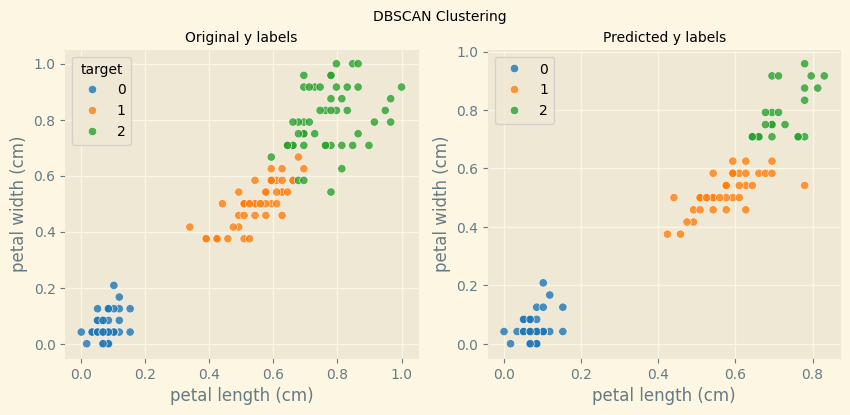

In [109]:
db_scan(X_train=iris_norm_min_max.iloc[:, [0, 3]], y_train=iris_y, eps=0.0525, min_sample=5, data=iris_norm_min_max)

### KNN classification

In [110]:
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(iris_norm, iris_y, test_size=0.33, random_state=42)

In [111]:
knn_model_iris = KNeighborsClassifier(n_neighbors=5)
knn_model_iris.fit(X_train_iris, y_train_iris)

y_pred_knn_iris = knn_model_iris.predict(X_test_iris)

report = classification_report(y_true=y_test_iris, y_pred=y_pred_knn_iris)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.94      1.00      0.97        15
           2       1.00      0.94      0.97        16

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



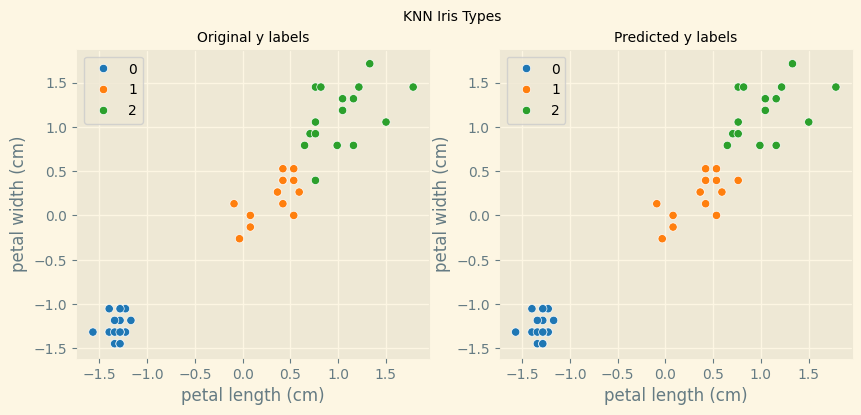

In [112]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle("KNN Iris Types", fontsize=10)

sns.scatterplot(data=X_test_iris, x="petal length (cm)", y="petal width (cm)", hue=np.array(y_test_iris), ax=axes[0], palette="tab10")
axes[0].set_title("Original y labels", fontsize=10)

sns.scatterplot(data=X_test_iris, x="petal length (cm)", y="petal width (cm)", hue=y_pred_knn_iris, ax=axes[1], palette="tab10")
axes[1].set_title("Predicted y labels", fontsize=10)

plt.show()